In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
import scanpy as sc
import anndata as ad
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy import stats
from scmuldiffusion.utils import MMD, LISI, random_forest, norm_total
import pandas as pd
from torch.distributions import Normal
from scvi.distributions import NegativeBinomial
from torch.distributions import Poisson, Bernoulli
import muon as mu
import yaml
import seaborn as sns  
from tqdm import tqdm

from scmuldiffusion.Autoencoder.data.scrnaseq_loader import RNAseqLoader
from scmuldiffusion.Autoencoder.models.base.encoder_model import EncoderModel

In [ ]:
encoder_config = "script/training_autoencoder/configs/encoder/encoder_multimodal.yaml"
dataset_path = '/stor/lep/diffusion/multiome/openproblem_filtered.h5mu'
covariate_keys = "cell_type" #"leiden"
num_class = 22
ae_path = "/stor/lep/workspace/scMulDiffusion/Autoencoder/project_folder/experiments/train_autoencoder_openproblem_multimodal/checkpoints/last.ckpt"

# load data

In [16]:
mdata = mu.read_h5mu(dataset_path)
gene_names = mdata['rna'].var_names
real_cell = mdata['rna'][::10].X.toarray()
real_cell2 = mdata['atac'][::10].X.toarray()
cell_type = mdata['rna'][::10].obs['cell_type'].values
type_list = np.unique(mdata['rna'][::10].obs['cell_type'].values)
real_cell.shape

(6925, 13431)

# Decode latent back to origin

In [ ]:
# get size factor for encoder
dataset = RNAseqLoader(data_path=dataset_path,
                            layer_key='X_counts',
                            covariate_keys=[covariate_keys],
                            subsample_frac=1, 
                            encoder_type='learnt_autoencoder',
                            multimodal=True,
                            is_binarized=True)

size_factor_statistics = {"mean": dataset.log_size_factor_mu, 
                            "sd": dataset.log_size_factor_sd}

def get_size_factor(type_index):
    covariate_indices = {}
    covariate_indices[covariate_keys] = type_index

    mean_size_factor, sd_size_factor = size_factor_statistics["mean"][covariate_keys], size_factor_statistics["sd"][covariate_keys]
    mean_size_factor, sd_size_factor = mean_size_factor[covariate_indices[covariate_keys]], sd_size_factor[covariate_indices[covariate_keys]]
    size_factor_dist = Normal(loc=mean_size_factor, scale=sd_size_factor)
    log_size_factor = size_factor_dist.sample().view(-1, 1)
    size_factor = torch.exp(log_size_factor)
    return {"rna": size_factor}

In [ ]:
# Load encoder and decoder
with open(encoder_config, 'r') as file:
    yaml_content = file.read()
autoencoder_args = yaml.safe_load(yaml_content)

# Initialize encoder
autoencoder_args['encoder_kwargs']['rna']['norm_type']='batchnorm'
autoencoder_args['encoder_kwargs']['atac']['norm_type']='batchnorm'
encoder_model = EncoderModel(in_dim={'atac': real_cell2.shape[1], 'rna': real_cell.shape[1]},
                                    n_cat=mdata['rna'].obs[covariate_keys].unique().shape[0],
                                    conditioning_covariate=covariate_keys, 
                                    encoder_type='learnt_autoencoder',
                                    **autoencoder_args)

# Load weights 
encoder_model.load_state_dict(torch.load(ae_path)["state_dict"])

<All keys matched successfully>

In [6]:
# read generated latent representation and decode back to gene expression/atac seq
rna_seq = np.load('../outputs/samples_new/w512_scale124_drop0_80w_rescale10_3crossatt64_condi/dpm_solver_80w_condi_big/RNA_0.npz')['data']
atac_seq = np.load('../outputs/samples_new/w512_scale124_drop0_80w_rescale10_3crossatt64_condi/dpm_solver_80w_condi_big/ATAC_0.npz')['data']
type_index = np.load('../outputs/samples_new/w512_scale124_drop0_80w_rescale10_3crossatt64_condi/dpm_solver_80w_condi_big/RNA_0.npz')['label']

# load norm factor for encoder
npzfile = np.load('/'.join(ae_path.split('/')[:-2])+'/norm_factor.npz')
rna_std = npzfile['rna_std']
atac_std = npzfile['atac_std']
z = {'rna':torch.tensor(rna_seq*rna_std).squeeze(1),'atac':torch.tensor(atac_seq*atac_std).squeeze(1)}

# get size factor and decode
size_factor = get_size_factor(torch.tensor(type_index,dtype=torch.int))
mu_hat = encoder_model.decode(z, size_factor)

sample = {}  # containing final samples 
for mod in mu_hat:
    if mod=="rna":  
        distr = NegativeBinomial(mu=mu_hat[mod], theta=torch.exp(encoder_model.theta))
    else:  # if mod is atac
        if not encoder_model.is_binarized:
            distr = Poisson(rate=mu_hat[mod])
        else:
            distr = Bernoulli(probs=mu_hat[mod])
    sample[mod] = distr.sample() 

reconstruct = sample['rna'][:real_cell.shape[0]].detach().numpy()
reconstruct2 = sample['atac'][:real_cell.shape[0]].detach().numpy()
type_index = type_index[:real_cell.shape[0]]

reconstruct.shape

(6925, 13431)

# evaluation

In [7]:
print('RNA')
print(real_cell.mean())
print(reconstruct.mean())
print('spearman=',stats.spearmanr(real_cell.mean(axis=0), reconstruct.mean(axis=0)).correlation)
print('pearson=',np.corrcoef(real_cell.mean(axis=0), reconstruct.mean(axis=0))[0][1])
print('MSE=',np.mean((reconstruct-real_cell)**2))
print('L2 Norm=',np.linalg.norm(reconstruct.mean(axis=0)-real_cell.mean(axis=0)))

print('\nATAC')
print(real_cell2.mean())
print(reconstruct2.mean())
print('spearman=',stats.spearmanr(real_cell2.mean(axis=0), reconstruct2.mean(axis=0)).correlation)
print('pearson=',np.corrcoef(real_cell2.mean(axis=0), reconstruct2.mean(axis=0))[0][1])
print('MSE=',np.mean((reconstruct2-real_cell2)**2))
print('L2 Norm=',np.linalg.norm(reconstruct2.mean(axis=0)-real_cell2.mean(axis=0)))

RNA
0.14379396
0.14475352
spearman= 0.9913733776473627
pearson= 0.987588422541502
MSE= 7.6237383
L2 Norm= 13.169576

ATAC
0.07920893
0.07917095
spearman= 0.9850661563393119
pearson= 0.9977483111114237
MSE= 0.13435104
L2 Norm= 0.97393376


In [8]:
print('RNA')
adata = np.concatenate((real_cell, reconstruct),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])])
print('MMD = ', MMD(adata))
print('LISI = ', LISI(adata))
print('AUC = ', random_forest(adata))

print('\nATAC')
adata = np.concatenate((real_cell2, reconstruct2),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs_names = [f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])]
sc.tl.pca(adata, svd_solver='arpack')
adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])])
print('MMD = ', MMD(adata))
print('LISI = ', LISI(adata))
print('AUC = ', random_forest(adata))

RNA


100%|██████████| 70/70 [00:16<00:00,  4.31it/s]


MMD =  tensor(0.0025)
LISI =  0.8510099970259501
AUC =  0.6675026483686849

ATAC


100%|██████████| 70/70 [00:15<00:00,  4.44it/s]


MMD =  tensor(0.0008)
LISI =  0.9244179941358288
AUC =  0.5611923262683485


umap

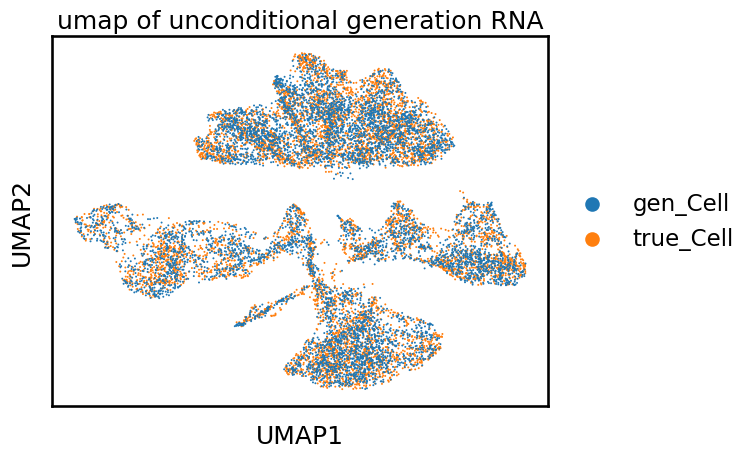

In [ ]:
adata = np.concatenate((real_cell, reconstruct),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)

adata.obs['cell_name'] = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]
adata.obs['cell_type'] = list(cell_type) + ['gen '+type_list[type] for type in type_index]

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.pl.umap(adata, color='cell_name', size=8, title='umap of unconditional generation RNA')
# plt.legend(loc = 'upper right')

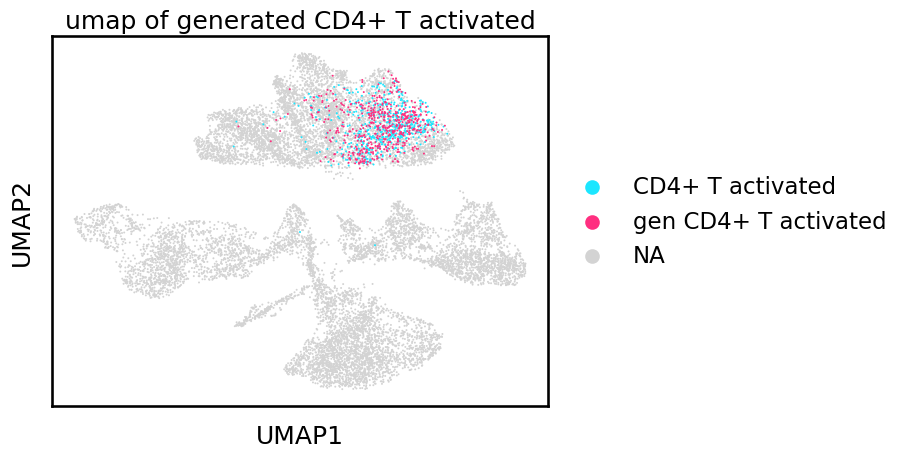

In [24]:
sc.pl.umap(adata, color='cell_type',groups=['CD4+ T activated','gen CD4+ T activated'], size=8, title='umap of generated CD4+ T activated')
# plt.legend(loc = 'upper right')

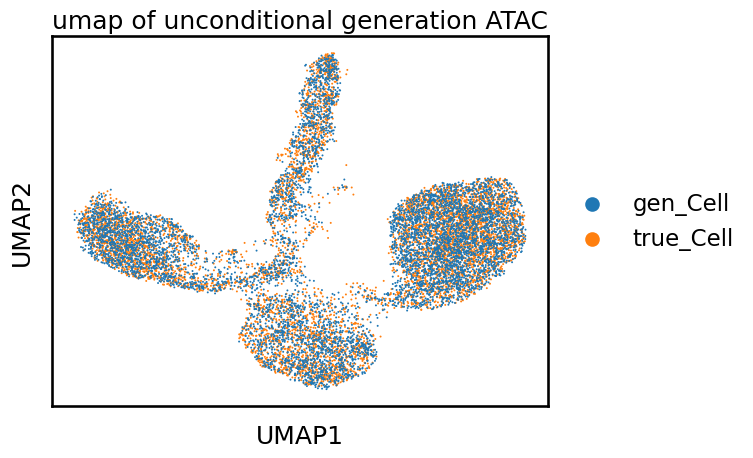

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


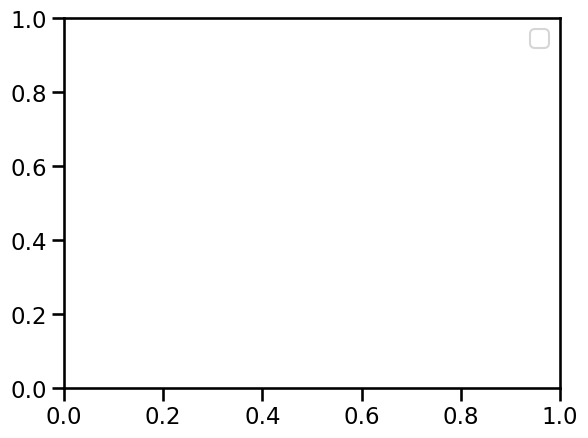

In [25]:
# # 再转回anndata便于scanpy处理
adata = np.concatenate((real_cell2, reconstruct2),axis=0)
adata = ad.AnnData(adata, dtype=np.float32)
# adata.var_names = gene_names
adata.obs['cell_name'] = [f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])]

sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)

# sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
# adata.raw = adata
# adata = adata[:, adata.var.highly_variable]

# sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

sc.pl.umap(adata, color='cell_name', size=8, title='umap of unconditional generation ATAC')
plt.legend(loc = 'upper right')

# pseudo time analysis

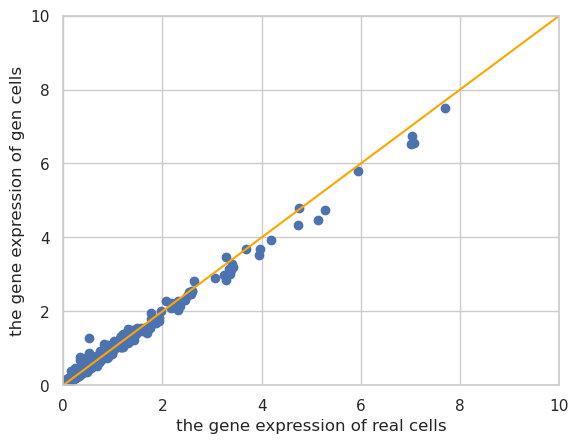

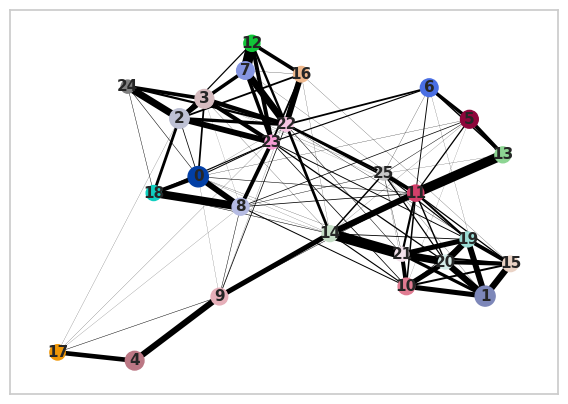

In [ ]:
# observe real cell's PAGA graph
adata_real = real_cell
adata_real = ad.AnnData(adata_real, dtype=np.float32)

sc.pp.normalize_total(adata_real, target_sum=1e4)
sc.pp.log1p(adata_real)

# sc.pp.highly_variable_genes(adata_real, min_mean=0.0125, max_mean=3, min_disp=0.5)
# adata_real.raw = adata_real
# adata_real = adata_real[:, adata_real.var.highly_variable]

# sc.pp.scale(adata)
sc.tl.pca(adata_real, svd_solver='arpack')
sc.pp.neighbors(adata_real, n_neighbors=10, n_pcs=20)
sc.tl.leiden(adata_real)

sc.tl.paga(adata_real, groups='leiden')

# 为了UMAP准备
sc.pl.paga(adata_real, plot=True)
sc.tl.umap(adata_real, init_pos='paga')

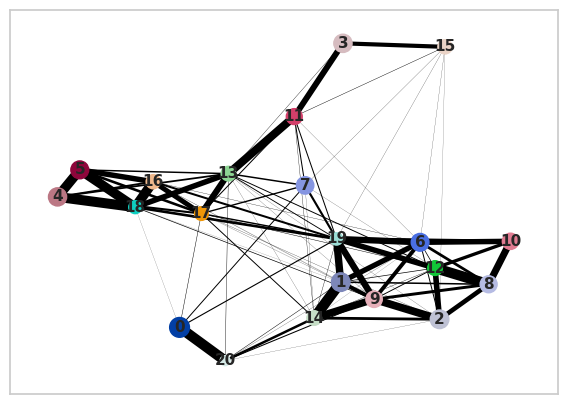

In [ ]:
# observe generated cell's PAGA graph
adata_recons = reconstruct
adata_recons = ad.AnnData(adata_recons, dtype=np.float32)

sc.pp.normalize_total(adata_recons, target_sum=1e4)
sc.pp.log1p(adata_recons)

# sc.pp.highly_variable_genes(adata_recons, min_mean=0.0125, max_mean=3, min_disp=0.5)
# adata_recons.raw = adata_recons
# adata_recons = adata_recons[:, adata_recons.var.highly_variable]

# sc.pp.scale(adata)
sc.tl.pca(adata_recons, svd_solver='arpack')
sc.pp.neighbors(adata_recons, n_neighbors=10, n_pcs=20)
sc.tl.leiden(adata_recons)
sc.tl.paga(adata_recons, groups='leiden')

# 为了UMAP准备
sc.pl.paga(adata_recons, plot=True)
sc.tl.umap(adata_recons, init_pos='paga')

In [ ]:
# choose a start point by the paga graph
adata_real.uns['iroot'] = np.flatnonzero(adata_real.obs['leiden'] == '17')[0]
sc.tl.dpt(adata_real)

adata_recons.uns['iroot'] = np.flatnonzero(adata_recons.obs['leiden'] == '15')[0]
sc.tl.dpt(adata_recons)

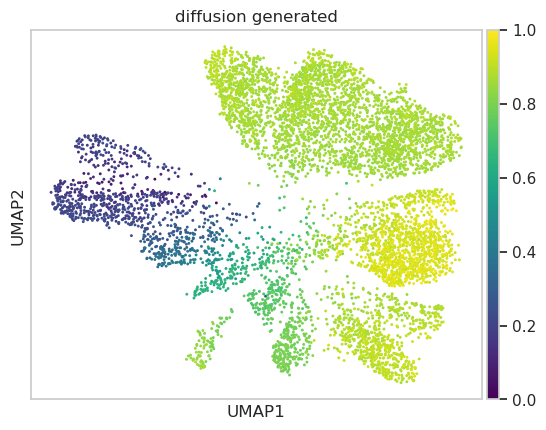

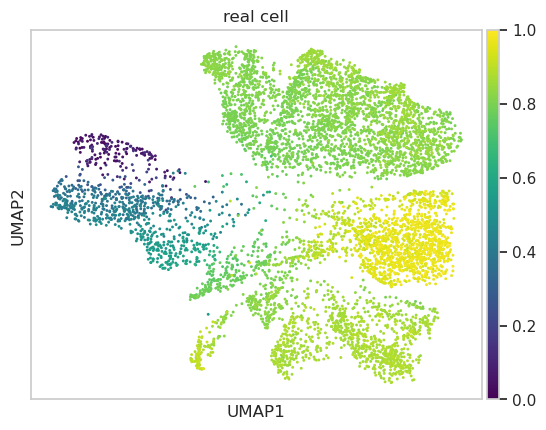

In [ ]:
adata = ad.AnnData(np.concatenate([real_cell,reconstruct]))#
adata.var_names = gene_names
adata.obs['dpt_pseudotime'] = list(adata_real.obs['dpt_pseudotime'].values)+list(adata_recons.obs['dpt_pseudotime'].values)
adata.obs['cell_name'] = ['true_cell']*real_cell.shape[0]+['diffusion']*reconstruct.shape[0]

adata.obs['leiden'] = list(adata_real.obs['leiden'].values) + list(adata_recons.obs['leiden'].values)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)

# UMAP, colored by pseudotime
dpt_pseudotime = adata.obs['dpt_pseudotime'].copy()
adata.obs.loc[adata.obs['cell_name'] != 'diffusion', 'dpt_pseudotime'] = np.nan
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sc.pl.umap(adata[adata.obs['cell_name']=='diffusion'], color=['dpt_pseudotime'], cmap='viridis',title='diffusion generated')

adata.obs['dpt_pseudotime'] = dpt_pseudotime
adata.obs.loc[adata.obs['cell_name'] != 'true_cell', 'dpt_pseudotime'] = np.nan
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sc.pl.umap(adata[adata.obs['cell_name']=='true_cell'], color=['dpt_pseudotime'], cmap='viridis',title='real cell')


In [155]:
print('spearman=',stats.spearmanr(np.sort(adata_real.obs['dpt_pseudotime'].values),np.sort(adata_recons.obs['dpt_pseudotime'].values)).correlation)
print('pearson=',np.corrcoef(np.sort(adata_real.obs['dpt_pseudotime'].values),np.sort(adata_recons.obs['dpt_pseudotime'].values))[0][1])

spearman= 0.999999999810294
pearson= 0.9469816375784955


# marker gene plot

gene correlation map

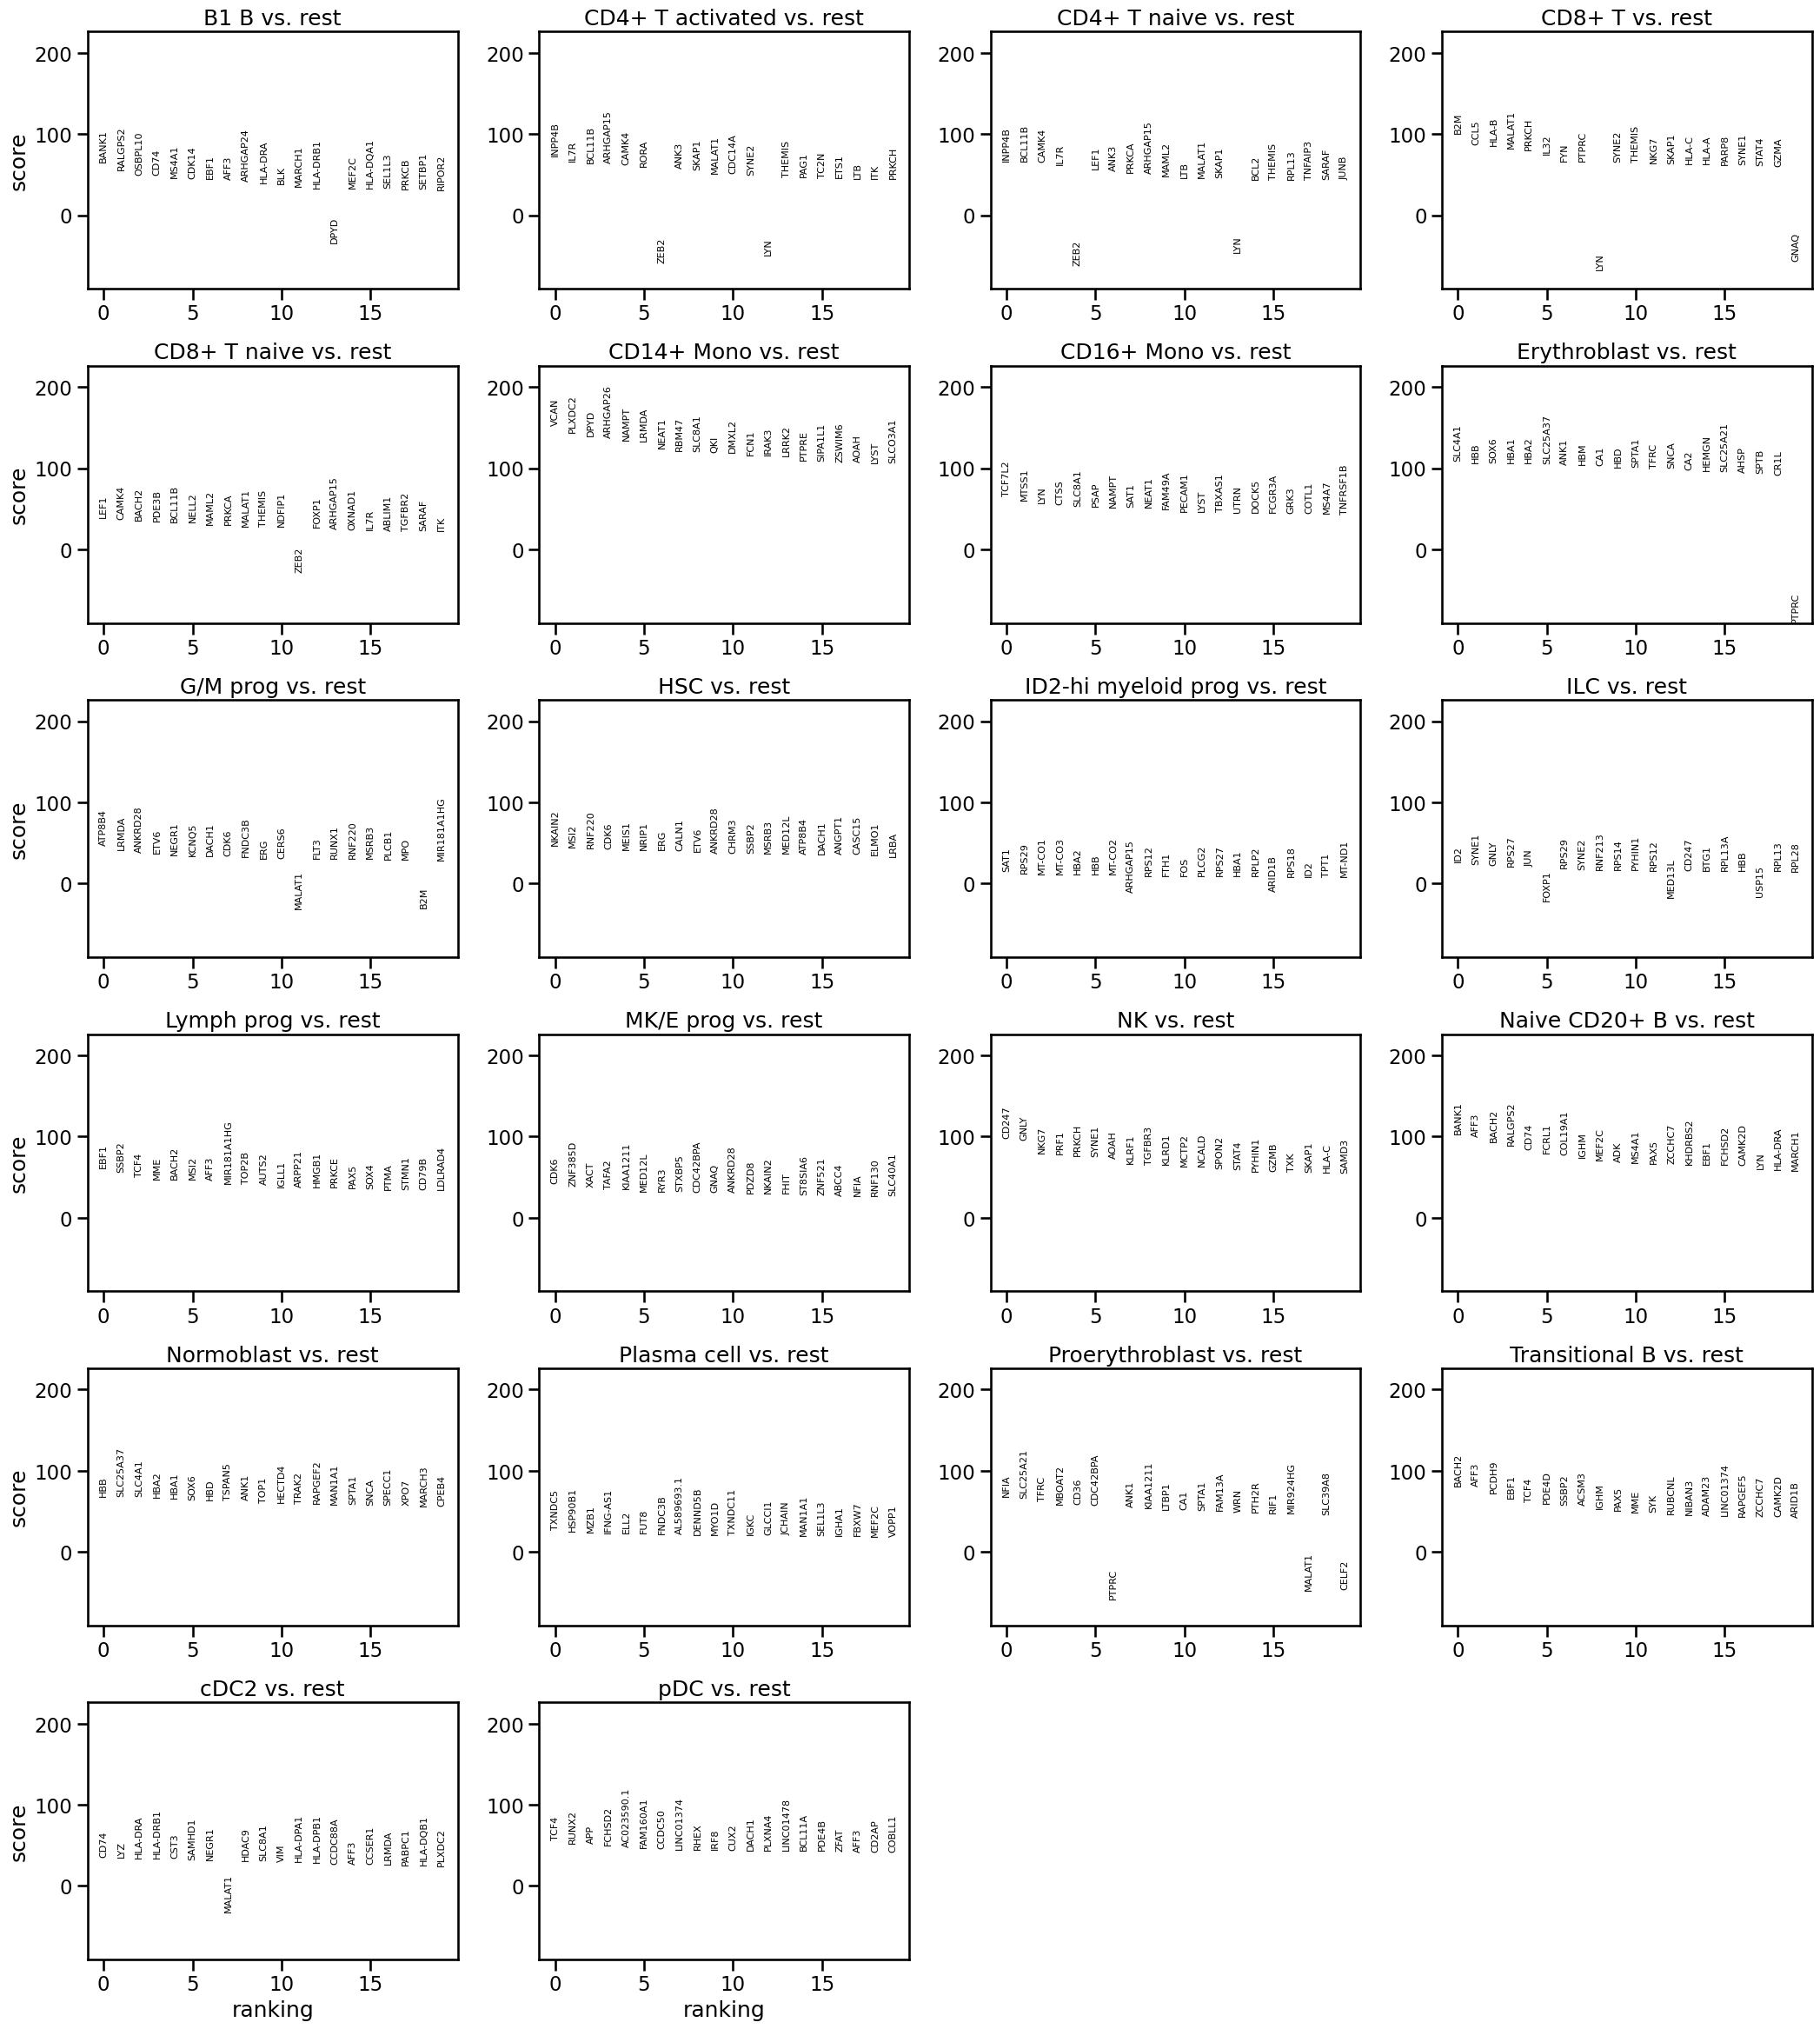

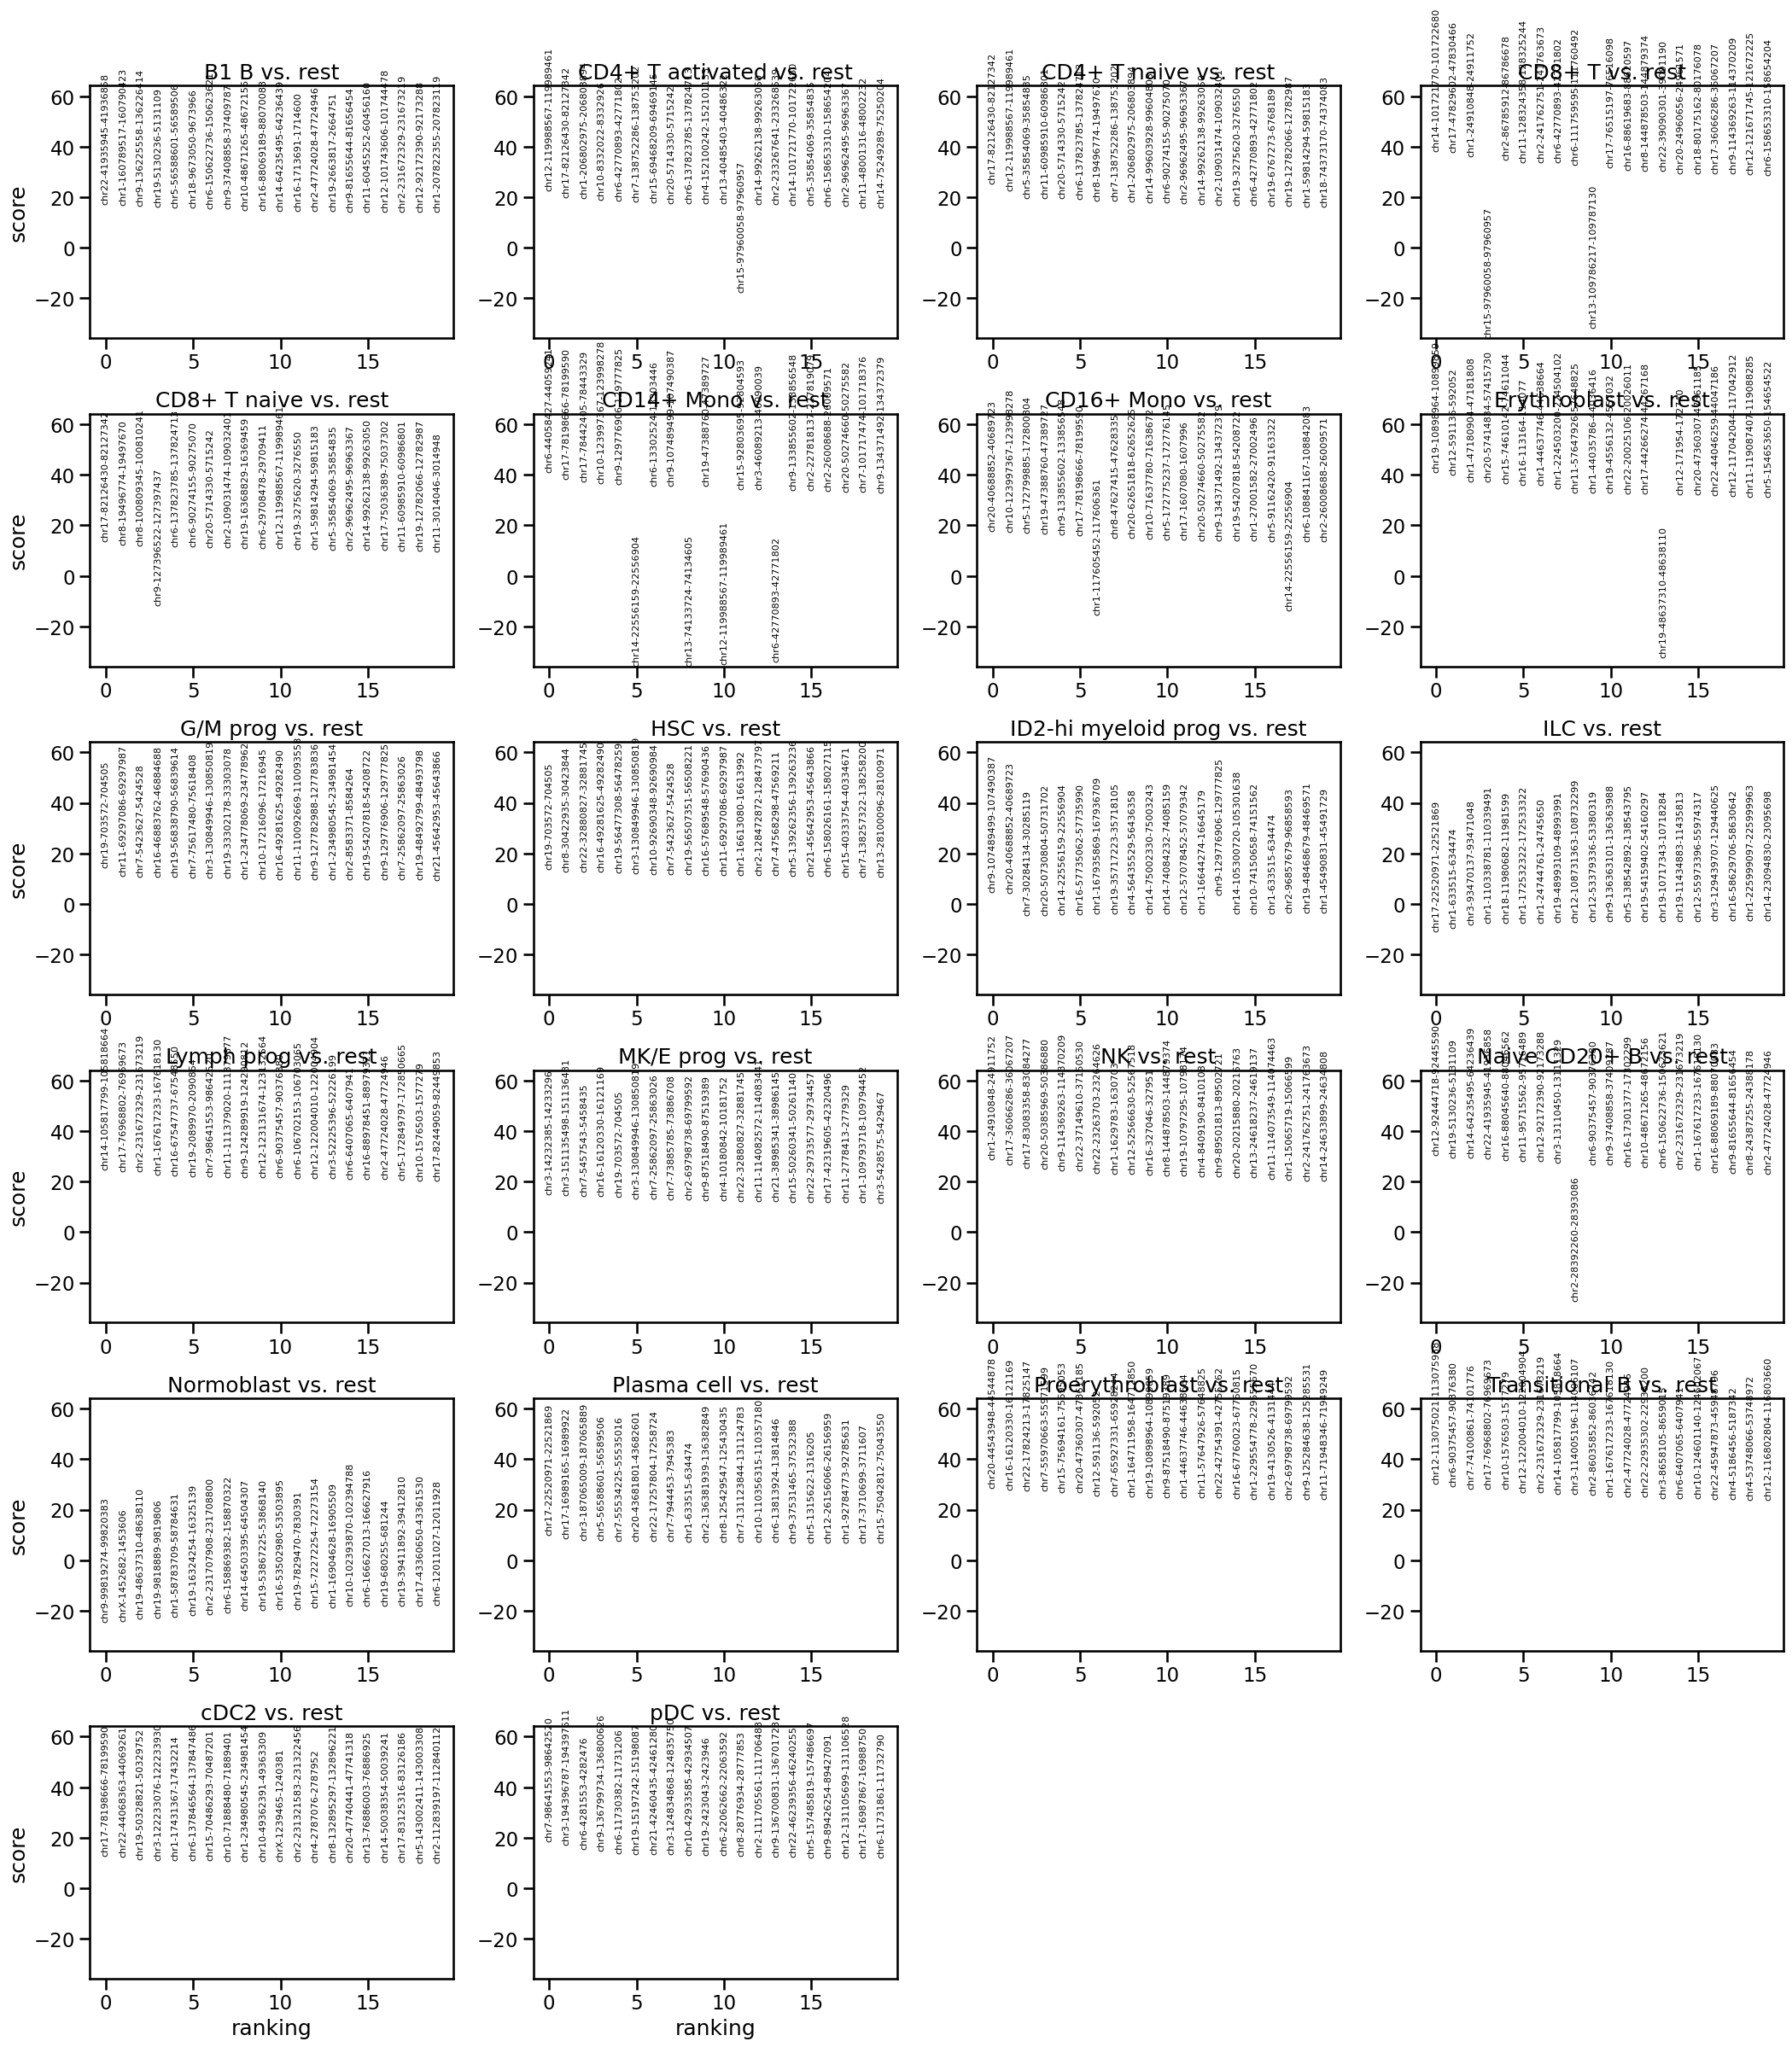

In [26]:
rna = mdata['rna']
atac = mdata['atac']

sc.pp.normalize_total(rna,1e4)
sc.pp.log1p(rna)
sc.tl.rank_genes_groups(rna,'cell_type', method='wilcoxon',rankby_abs=True) 
sc.pl.rank_genes_groups(rna)

sc.tl.rank_genes_groups(atac,'cell_type', method='wilcoxon',rankby_abs=True) 
sc.pl.rank_genes_groups(atac)


In [37]:
# reconstruct = norm_total(np.array(reconstruct),1e4)
# sc.pp.normalize_total(mdata['rna'],1e4)

index_marker = np.array([np.where(mdata['rna'].var_names.values == x)[0][0] for x in rna.uns['rank_genes_groups']['names'][0]])
real_marker = mdata['rna'][:,index_marker].X.toarray()
gen_marker = reconstruct[:, index_marker]
type_list = mdata['rna'].obs['cell_type'].values

gen_marker = [gen_marker[type_index==i].mean(0) for i in range(np.unique(type_index).shape[0])]
gen_marker = np.stack(gen_marker,axis=0)
real_marker = [real_marker[type_list==i].mean(0) for i in np.unique(type_list)]
real_marker = np.stack(real_marker,axis=0)
# real_marker.shape, gen_marker.shape
pearson_matrix = np.zeros((22,22))
for i in tqdm(range(22)):
    for j in range(22):
        if i<j:
            pearson_matrix[i,j] = np.corrcoef(real_marker[:,i], real_marker[:,j])[0][1]
        else:
            pearson_matrix[i,j] = np.corrcoef(gen_marker[:,i], gen_marker[:,j])[0][1]

100%|██████████| 22/22 [00:00<00:00, 1124.90it/s]


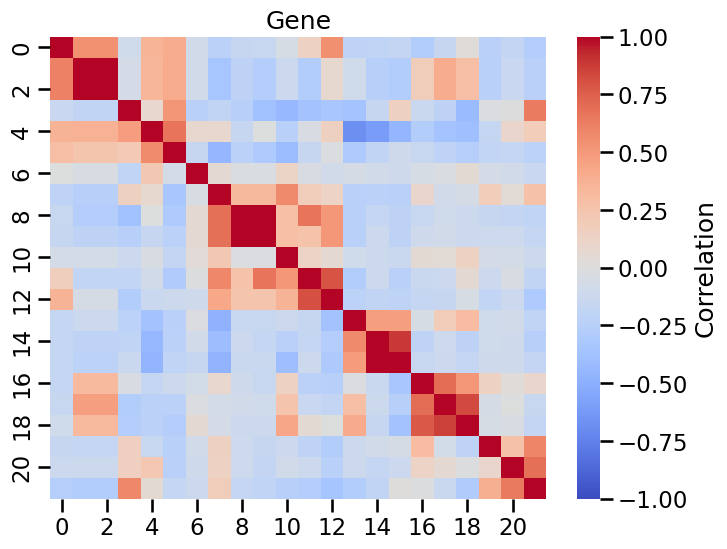

In [38]:
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from scipy.spatial.distance import squareform

matrix = pearson_matrix
matrix = (matrix + matrix.T) / 2  # Symmetrize the matrix
np.fill_diagonal(matrix, 1)  # Set diagonal to 1 for correlation-like matrix

# Perform hierarchical clustering
distance_matrix = 1 - matrix  # Convert correlation to distance
condensed_distance_matrix = squareform(distance_matrix, checks=False)  # Convert to condensed form
linkage_matrix = linkage(condensed_distance_matrix, method='ward')  # Apply hierarchical clustering
ordered_indices = leaves_list(linkage_matrix)  # Get the leaf order

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.figure(figsize=(8, 6))
# 使用seaborn绘制热图
reordered_pearson_matrix = pearson_matrix[np.ix_(ordered_indices, ordered_indices)]
sns.heatmap(reordered_pearson_matrix, 
            annot=False,         
            cmap='coolwarm',    
            center=0,           
            vmin=-1,            
            vmax=1,            
            cbar_kws={'label': 'Correlation'}) 

# 显示图形
plt.title('Gene')
plt.show()

In [39]:
index_marker = np.array([np.where(mdata['atac'].var_names.values == x)[0][0] for x in atac.uns['rank_genes_groups']['names'][0]])
real_marker = mdata['atac'][:,index_marker].X.toarray()
gen_marker = reconstruct2[:, index_marker]
type_list = mdata['rna'].obs['cell_type'].values

gen_marker = [gen_marker[type_index==i].mean(0) for i in range(np.unique(type_index).shape[0])]
gen_marker = np.stack(gen_marker,axis=0)
real_marker = [real_marker[type_list==i].mean(0) for i in np.unique(type_list)]
real_marker = np.stack(real_marker,axis=0)
# real_marker.shape, gen_marker.shape
pearson_matrix2 = np.zeros((22,22))
for i in tqdm(range(22)):
    for j in range(22):
        if i<j:
            pearson_matrix2[i,j] = np.corrcoef(real_marker[:,i], real_marker[:,j])[0][1]
        else:
            pearson_matrix2[i,j] = np.corrcoef(gen_marker[:,i], gen_marker[:,j])[0][1]

100%|██████████| 22/22 [00:00<00:00, 1145.71it/s]


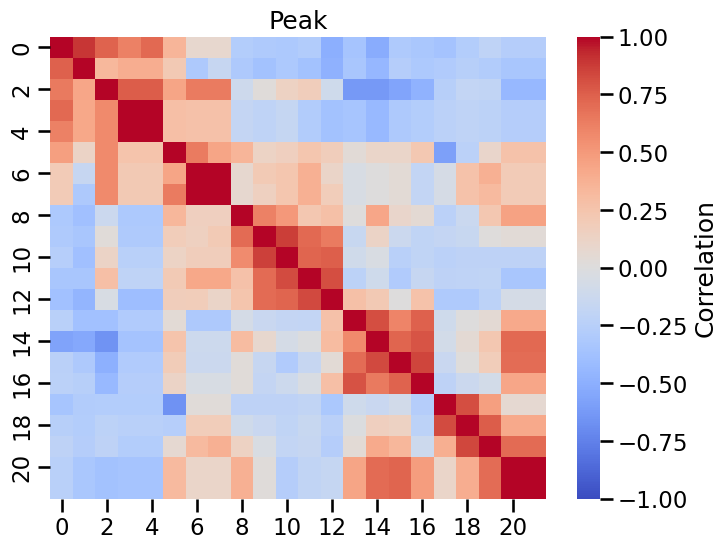

In [40]:
matrix = pearson_matrix2
matrix = (matrix + matrix.T) / 2  # Symmetrize the matrix
np.fill_diagonal(matrix, 1)  # Set diagonal to 1 for correlation-like matrix

# Perform hierarchical clustering
distance_matrix = 1 - matrix  # Convert correlation to distance
condensed_distance_matrix = squareform(distance_matrix, checks=False)  # Convert to condensed form
linkage_matrix = linkage(condensed_distance_matrix, method='ward')  # Apply hierarchical clustering
ordered_indices = leaves_list(linkage_matrix)  # Get the leaf order

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.figure(figsize=(8, 6))
reordered_pearson_matrix2 = pearson_matrix2[np.ix_(ordered_indices, ordered_indices)]
sns.heatmap(reordered_pearson_matrix2, 
            annot=False,         
            cmap='coolwarm',    
            center=0,          
            vmin=-1,           
            vmax=1,           
            cbar_kws={'label': 'Correlation'}) 

plt.title('Peak')
plt.show()

# evaluate different cell type

In [ ]:
from tqdm import tqdm
type_list = ['B1 B', 'CD14+ Mono', 'CD16+ Mono', 'CD4+ T activated',
        'CD4+ T naive', 'CD8+ T', 'CD8+ T naive', 'Erythroblast',
        'G/M prog', 'HSC', 'ID2-hi myeloid prog', 'ILC', 'Lymph prog',
        'MK/E prog', 'NK', 'Naive CD20+ B', 'Normoblast', 'Plasma cell',
        'Proerythroblast', 'Transitional B', 'cDC2', 'pDC']
columns = ['cell type', 'RNA PCC', 'RNA SCC', 'RNA MMD', 'RNA LISI', 'RNA AUC', 'ATAC PCC', 'ATAC SCC', 'ATAC MMD', 'ATAC LISI', 'ATAC AUC']
type_index = np.load('../outputs/samples_new/w512_scale124_drop0_80w_rescale10_3crossatt64_condi/dpm_solver_80w_condi_big/RNA_0.npz')['label'] # here we use all sampled data
df = pd.DataFrame(columns=columns)
for id, type in enumerate(type_list):
    # load different cell type and control the number of each type (to save evaluation time)
    total = (mdata['rna'].obs['cell_type']==type).sum()
    sample_index = np.random.choice(total, size=800, replace=False) if total>=800 else list(range(total))
    real_cell = mdata['rna'][mdata['rna'].obs['cell_type']==type].X.toarray()[sample_index]
    real_cell2 = mdata['atac'][mdata['atac'].obs['cell_type']==type].X.toarray()[sample_index]
    cell_num = min((type_index==id).sum(),real_cell.shape[0])
    reconstruct = sample['rna'][type_index==id][:cell_num].detach().numpy()
    reconstruct2 = sample['atac'][type_index==id][:cell_num].detach().numpy()
    real_cell = real_cell[:cell_num]
    real_cell2 = real_cell2[:cell_num]

    # calculate evaluation metric
    rna_scc = stats.spearmanr(real_cell.mean(axis=0), reconstruct.mean(axis=0)).correlation
    rna_pcc = np.corrcoef(real_cell.mean(axis=0), reconstruct.mean(axis=0))[0][1]
    atac_scc = stats.spearmanr(real_cell2.mean(axis=0), reconstruct2.mean(axis=0)).correlation
    atac_pcc = np.corrcoef(real_cell2.mean(axis=0), reconstruct2.mean(axis=0))[0][1]

    adata = np.concatenate((real_cell, reconstruct),axis=0)
    adata = ad.AnnData(adata, dtype=np.float32)
    adata.obs_names = [f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])]
    sc.tl.pca(adata, svd_solver='arpack')
    adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell.shape[0])]+[f"gen_Cell" for i in range(reconstruct.shape[0])])
    rna_mmd = MMD(adata)
    rna_lisi = LISI(adata)
    rna_auc = random_forest(adata)

    adata = np.concatenate((real_cell2, reconstruct2),axis=0)
    adata = ad.AnnData(adata, dtype=np.float32)
    adata.obs_names = [f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])]
    sc.tl.pca(adata, svd_solver='arpack')
    adata.obs['batch'] = pd.Categorical([f"true_Cell" for i in range(real_cell2.shape[0])]+[f"gen_Cell" for i in range(reconstruct2.shape[0])])
    atac_mmd = MMD(adata)
    atac_lisi = LISI(adata)
    atac_auc = random_forest(adata)

    df.loc[id] = [type, rna_pcc, rna_scc, rna_mmd, rna_lisi, rna_auc, atac_pcc, atac_scc, atac_mmd, atac_lisi, atac_auc]

100%|██████████| 9/9 [00:00<00:00, 88.48it/s]


In [ ]:
df.to_csv('eval_results/diffusion.csv', index=False) # save it if you want
df

,cell type,RNA PCC,RNA SCC,RNA MMD,RNA LISI,RNA AUC,ATAC PCC,ATAC SCC,ATAC MMD,ATAC LISI,ATAC AUC
0,B1 B,0.987566,0.967615,tensor(0.0150),0.833364,0.797694,0.986721,0.979733,tensor(0.0106),0.899214,0.595788
1,CD14+ Mono,0.992969,0.975501,tensor(0.0269),0.873068,0.677646,0.981683,0.975874,tensor(0.0077),0.905203,0.597564
2,CD16+ Mono,0.995610,0.982333,tensor(0.0422),0.806425,0.786214,0.982685,0.974554,tensor(0.0622),0.847424,0.660114
3,CD4+ T activated,0.997701,0.972190,tensor(0.0183),0.879269,0.670718,0.988320,0.978231,tensor(0.0072),0.888342,0.633578
4,CD4+ T naive,0.997946,0.974163,tensor(0.0353),0.839855,0.745648,0.989293,0.979403,tensor(0.0133),0.877567,0.604692
5,CD8+ T,0.996127,0.969788,tensor(0.0249),0.784428,0.730742,0.987550,0.979525,tensor(0.0238),0.911457,0.639081
6,CD8+ T naive,0.995426,0.973165,tensor(0.0270),0.806572,0.658188,0.990184,0.981577,tensor(0.0188),0.891647,0.647134
7,Erythroblast,0.998432,0.977005,tensor(0.0042),0.922589,0.734019,0.989771,0.966028,tensor(0.0187),0.886622,0.719638
8,G/M prog,0.981477,0.979162,tensor(0.0316),0.823997,0.794243,0.981967,0.969076,tensor(0.0131),0.892188,0.690201
9,HSC,0.987696,0.978155,tensor(0.0364),0.797329,0.767057,0.983788,0.974396,tensor(0.0166),0.853439,0.715586
